## Low value and 2-connected components

1. Use a recursive implementation of the depth-first search given below (from previuos exercises).
   Add computation of __low__ value, see "Lecture Notes/Course Handouts".
2. Find cutvertices.
3. Partition the edges into 2-connected components (blocks).

You can assume that the graphs are connected.

In [ ]:
def DFS_with_times(G, r):
    """
    Perform DFS from root r. Result is a triple of three dictionaries:
    - dictionary mapping a vertex v to its predecessor in DFS tree (root is mapped to None).
    - dictionary mapping a vertex to its discovery (start) time
    """    
    global time
    time = 0
    prev = {}
    disc = {}
    # finish = {}
    prev[r] = None
    DFS_with_times_call(G, r, prev, disc)
    return (prev, disc)    
    
def DFS_with_times_call(G, v, prev, disc):
    global time
    time += 1;
    disc[v] = time;
    for u in G.neighbors(v):
        if u not in prev:
            prev[u] = v
            DFS_with_times_call(G, u, prev, disc, finish)
    # time += 1;
    # finish[v] = time;

#### 1. Low value

For a vertex $v$ `low[v]` is the smallest discovery time `disc[x]` over all vertices $x$ which can be reached from $v$
using tree edges (away from the root) -- red edges -- and at most one back edge -- black edge.


In the example below labels of vertices are (vertex name, discovery time, low value) and arrows indicate parent of a vertex in the DFS tree (prev):
* `low[2]` is 1 since we can reach the root (with discovery time 1) using red edge (2, 3) and black edge (3, 1)
* `low[8]` is 3 since the vertex with the smallest discovery time we can reach in the prescribed way is 3: edges are (8, 7), (7, 9), (9, 3) and 3 has discovery time 3
* `low[10]` is 8 (its discovery time) since we can not reach any vertex with smaller discovery time using the tree edges "below" 10.


![alt text](low.png "Title")

In [18]:
def DFS_low(G, r):
    """
    Perform DFS from root r. Result is a triple of three dictionaries:
    - dictionary mapping a vertex v to its predecessor in DFS tree (root is mapped to None).
    - dictionary mapping a vertex to its discovery time
    - dictionary mapping a vertex to its low value
    """    
    global time
    time = 0
    prev = {}
    disc = {}
    low = {}
    prev[r] = None
    DFS_low_call(G, r, prev, disc, low)
    return (prev, disc, low)    
    
def DFS_low_call(G, v, prev, disc, low):
    global time
    time += 1
    disc[v] = time
    low[v] = time
    for u in G.neighbors(v):
        if u not in prev:
            prev[u] = v
            DFS_low_call(G, u, prev, disc, low)
    # calc low here...
    for u in G.neighbors(v):
        if v == prev[u]:
            low[v] = min(low[v], low[u])
        elif prev[v] != u:
            low[v] = min(low[v], disc[u])




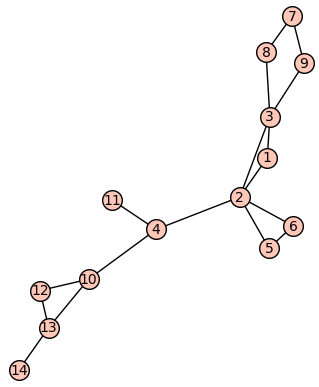

In [15]:
G = Graph({1:[2,3], 2:[3,4,5,6], 3:[8,9], 4:[10,11], 5:[6], 7:[8,9], 10:[12,13], 12:[13], 13:[14]})
G.plot()

Run algorithm from vertex 1 

In [20]:
prev, disc, low = DFS_low(G, 1)

In [21]:
low

{1: 1,
 2: 1,
 3: 1,
 8: 3,
 7: 3,
 9: 3,
 4: 7,
 10: 8,
 12: 8,
 13: 8,
 14: 11,
 11: 12,
 5: 2,
 6: 2}

Relabel vertices with triples `(vertex label, discovery time, low value)` and color tree edges red

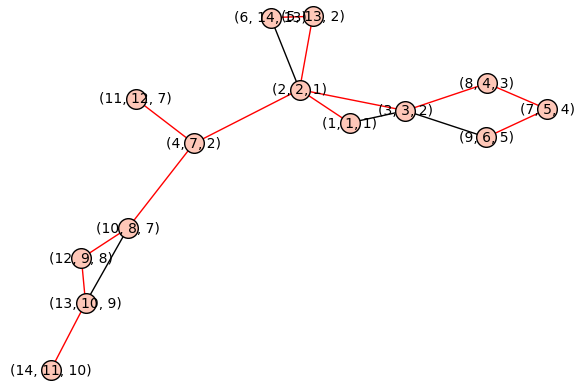

In [13]:
G1 = G.relabel(dict([(v, (v, disc[v], low[v])) for v in G.vertices(sort=False)]), inplace=False)
G1.plot(edge_colors={'red': [((u, disc[u], low[u]), (v, disc[v], low[v])) for (u, v) in prev.items() if v != None]})

#### 2. cutvertices

We can get cutvertices using the following Theorem (See Lecture Notes/Handouts).

Theorem: Let `G` be connected, undirected, simple, let `r` be the root of its `DFS` tree `T`:
* `r` is a cutvertex if is incident with ≥ 2 tree edges
* nonroot vertex `v` is a cutvertex if `v` has a son `y` so that `low[y]` ≥ `disc[v]`

In the example above, cutvertices are 2, 3, 4, 10, 13. For example 10 is a cut vertex, since its son in the tree has low value 8 which is >= than discovery time of 10, `disc[10]` == 8

Also 4 is a cutvertex since its sons (11 and 10) have low values >= 7 (7 = `disc[4]`).

The root 1 is not a cutvertex since it is incident with only one tree edge


In [26]:
def cutvertices(G):
    """
    Retuns an array of cutvertices of a connected graph G.
    """
    cutvertices = []
    root = G.vertices()[0]     # assume G is connected
    (prev, disc, low) = DFS_low(G, root)
    for v in G.vertices():
        if v == root:
            count = 0
            for u in G.neighbors(v):
                if prev[v] == u:
                    count += 1
            if count > 1:
                cutvertices.append(v)
        else:
            for u in G.neighbors(v):
                if low[u] >= disc[v]:
                    cutvertices.append(v)
    return list(set(cutvertices))

    # .....
    # .....

In [27]:
cutvertices(G)

[2, 3, 4, 10, 13]

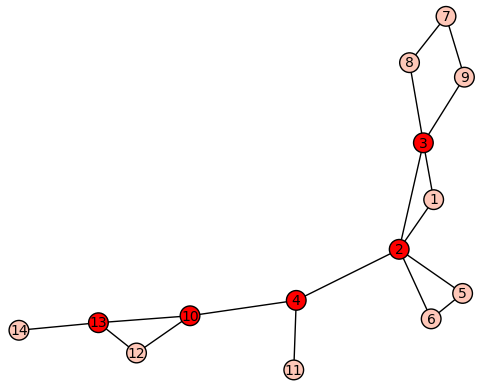

In [28]:
plot(G, vertex_colors={'red': cutvertices(G)})

#### 3. partition into blocks

Write a function `partition[G]` which partitions edges of G into blocks (2-connected components)

Output should be a dictionary which maps an edge of the graph into a number which represents a block. In the example above, vertices 1, 2, 3 (edges (1,2), (1,3), (2,3)) create a block. Therefore the resulting dictionary should map the pairs (1,2), (1,3), (2,3) into the same number, say 1.

In [ ]:
def partition(G):
    """"
    Partitions of edges of a connected graph G into blocks.
    Returns a dictionary mapping each edge to the block (number) it belongs to.
    """
    global blocknum
    root = G.vertices()[0]     # assume G is connected
    (prev, disc, low) = DFS_low(G, root)
    blocknum = 0
    blocks = {}
    partition_call(G, root, prev, disc, low, blocks, 0)
    return blocks

    
def partition_call(G, v, prev, disc, low, blocks, blockn):
    global blocknum        
    for u in G.neighbors(v):
        if prev[u] == v:
            # v is the son of u in the DFS tree
            if low[u] >= disc[v]:
                blocknum += 1
                blockn = blocknum
            blocks[(u, v)] = blockn
        elif prev[v] != u and (u,v) not in blocks:
            # this is a back edge
            # TODO: this 

            pass
    # .........
    # .........

Example for the graph above

In [ ]:
partition(G)

{(1, 2): 1,
 (2, 3): 1,
 (1, 3): 1,
 (3, 8): 2,
 (8, 7): 2,
 (7, 9): 2,
 (3, 9): 2,
 (2, 4): 3,
 (4, 10): 4,
 (10, 12): 5,
 (12, 13): 5,
 (10, 13): 5,
 (13, 14): 6,
 (4, 11): 7,
 (2, 5): 8,
 (5, 6): 8,
 (2, 6): 8}

Color each block with a different color:

In [ ]:
import random
def edge_colors(part):
    blocks = set(part.values())
    colors = [(random.random(), random.random(), random.random()) for b in blocks]
    colorblocks = [[edge for edge in part.keys() if part[edge] == b] for b in blocks]
    return dict(zip(colors, colorblocks))

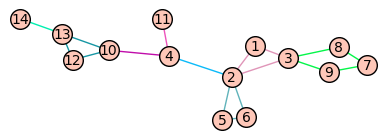

In [ ]:
G.show(edge_colors = edge_colors(partition(G)))

### More examples:

In [ ]:
D = graphs.DodecahedralGraph()

In [ ]:
cutvertices(D)

[]

In [ ]:
partition(D)

{(0, 1): 1,
 (1, 2): 1,
 (2, 3): 1,
 (3, 19): 1,
 (0, 19): 1,
 (19, 18): 1,
 (18, 17): 1,
 (17, 16): 1,
 (16, 12): 1,
 (12, 11): 1,
 (18, 11): 1,
 (11, 10): 1,
 (0, 10): 1,
 (10, 9): 1,
 (9, 8): 1,
 (1, 8): 1,
 (8, 7): 1,
 (7, 6): 1,
 (2, 6): 1,
 (6, 5): 1,
 (5, 4): 1,
 (17, 4): 1,
 (3, 4): 1,
 (5, 15): 1,
 (16, 15): 1,
 (15, 14): 1,
 (7, 14): 1,
 (14, 13): 1,
 (9, 13): 1,
 (12, 13): 1}

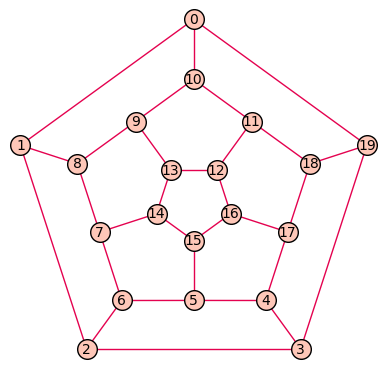

In [ ]:
D.show(edge_colors = edge_colors(partition(D)))

In [ ]:
G.show(edge_colors = edge_colors(partition(G)))

In [ ]:
D1 = graphs.StarGraph(10)

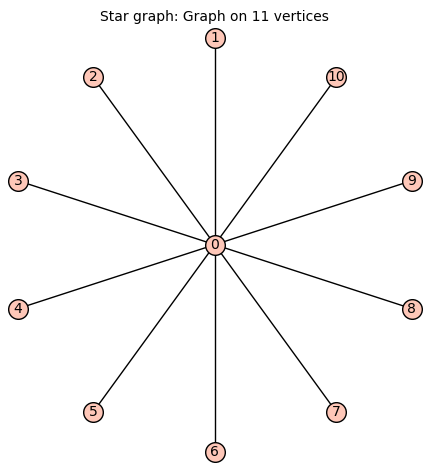

In [ ]:
D1

In [ ]:
cutvertices(D1)

[0]

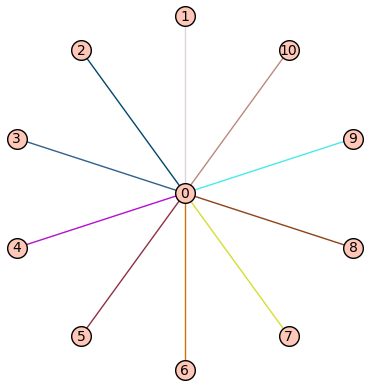

In [ ]:
D1.show(edge_colors = edge_colors(partition(D1)))